In [ ]:
from tensorflow.keras import layers, Model
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob
from tqdm import tqdm

In [ ]:
class AutoEncoder3DOld: # Works but it uses 2d convolutional layers >:(
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling2D((2, 2), padding="same")(encoded)

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 8))  # Shape of encoded latent space
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(170, (3, 3), activation="relu", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

        return

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

In [2]:

class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Downscale
        x = layers.Dropout(0.1)(x)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale
        
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale

        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)  # Latent space
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Final downscale for compact latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(16, 16, 11, 8))  # Adjust latent space shape (smaller)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        
        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)

        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Final upscale to original shape
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)  # Sigmoid for [0, 1] range output

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

In [3]:
scan_paths = glob.glob("C:/Users/PieHu/Documents/GitHub/DementiaMRI/Data/Pre-processed/Scaled and padded/**/*.nii", recursive=True)
scans = []

for path in tqdm(scan_paths, desc="Loading scans"):
    path = path.replace("\\","/")
    scans.append(nib.load(path).get_fdata())
scans = np.array(scans)
scans.shape

(59, 256, 256, 176)

In [4]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = AutoEncoder3D(input_shape)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 176,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16, 16, 11, 8)  │         4,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 176,  │         6,185 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,641 (41.57 KB)

 Trainable params: 10,641 (41.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step - loss: 12818.5381 - val_loss: 14219.0352
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 12797.0508 - val_loss: 14211.2227
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12787.5781 - val_loss: 14208.8457
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12784.4209 - val_loss: 14208.2148
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12783.5498 - val_loss: 14207.9404
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12783.1797 - val_loss: 14207.7910
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12782.9883 - val_loss: 14207.7129
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12782.8906 - val_loss: 14207.6699
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12782.8398 - val_loss: 14207.6367
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12782.8057 - val_loss: 14207.6055
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12782.7773 - val_loss: 14207.5771
Epoch 12/40
1/1 ━

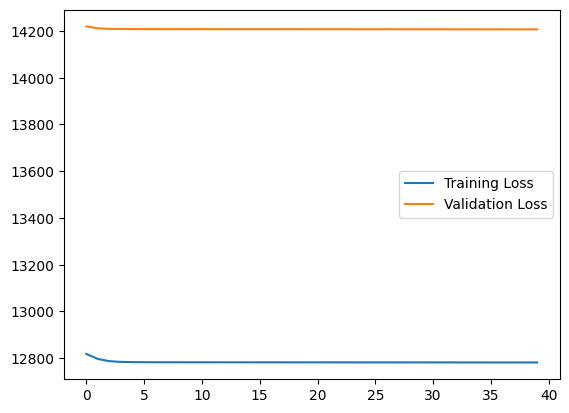

In [5]:
history = autoencoder.train(scans[:8], epochs=40, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


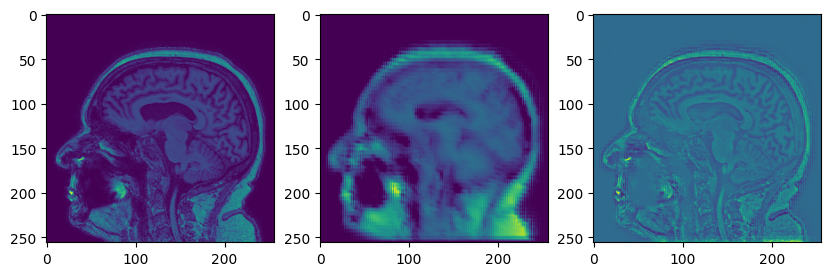

In [34]:
test_idx = 20
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,3,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,80])
ax[1].imshow(recon[0,:,:,80])
ax[2].imshow(scans[test_idx][:,:,80]-recon[0].reshape(256,256,172)[:,:,80])